Data Pre-Processing

In [11]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/content/BostonHousing.csv')

# Inspect the data
print(df.head())

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [12]:
# Check for missing values
print(df.isnull().sum())

# Handle missing values (if any)
df = df.dropna()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


In [13]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [15]:
# checking the range of rm column

print(max(df['rm']))
print(min(df['rm']))


8.78
3.561


Using PySpark for binning based on average number of rooms.

In [5]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=84a2ff6e7ad35e830aa0c460e25841a0e07b550de81ee6fac514cab08c86e86a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean

# Initialize Spark Session
spark = SparkSession.builder.appName("BostonHousing").getOrCreate()

# Load the data
data = spark.read.csv("/content/BostonHousing.csv", sep=",", header = True, inferSchema=True)

In [7]:
data.printSchema()

root
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- b: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [8]:
data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [16]:
# Data Preparation
data = data.na.drop()

# Binning based on RM
bins = [3, 4, 5, 6, 7, 8, 9]
data = data.withColumn("rm_bin", col("rm").cast("int"))

# Calculate statistics for each bin
statistics = data.groupBy("rm_bin").agg(
    mean("medv").alias("average_medv"),
    mean("age").alias("average_age"),
    mean("tax").alias("average_tax")
)

# Show results
statistics.show()

+------+------------------+------------------+------------------+
|rm_bin|      average_medv|       average_age|       average_tax|
+------+------------------+------------------+------------------+
|     6| 22.01598513011151| 65.53866171003715|407.97026022304834|
|     3|              25.3|             93.95|             666.0|
|     5|17.487341772151893| 74.59620253164557| 428.7278481012658|
|     4|16.023076923076925| 93.37692307692308| 597.6923076923077|
|     8|              44.2| 71.53846153846153| 325.0769230769231|
|     7|36.917647058823526|57.862745098039234|308.96078431372547|
+------+------------------+------------------+------------------+



In [17]:
# Convert PySpark DataFrame to Pandas DataFrame for plotting
statistics_pd = statistics.toPandas()

In [16]:
# Stop Spark Session
spark.stop()

Visualizations

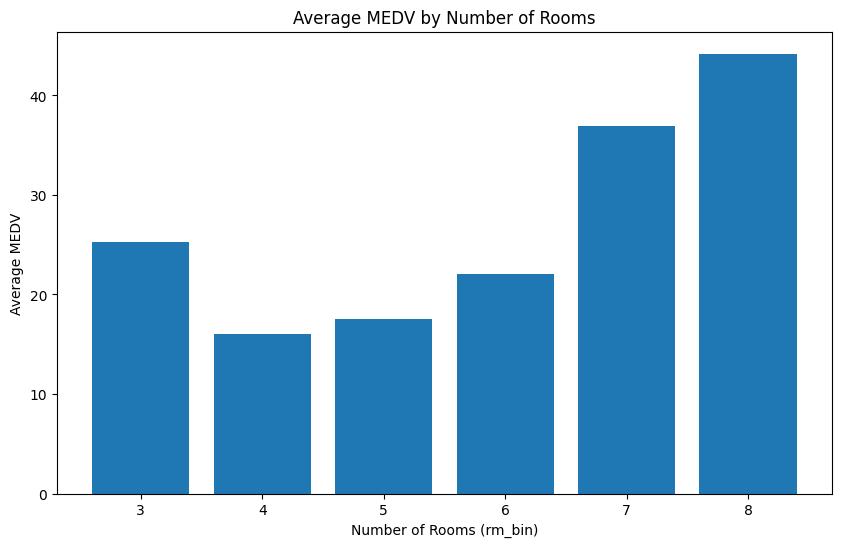

In [18]:
import matplotlib.pyplot as plt

# Bar chart for average_MEDV
plt.figure(figsize=(10, 6))
plt.bar(statistics_pd['rm_bin'], statistics_pd['average_medv'])
plt.xlabel('Number of Rooms (rm_bin)')
plt.ylabel('Average MEDV')
plt.title('Average MEDV by Number of Rooms')
plt.show()

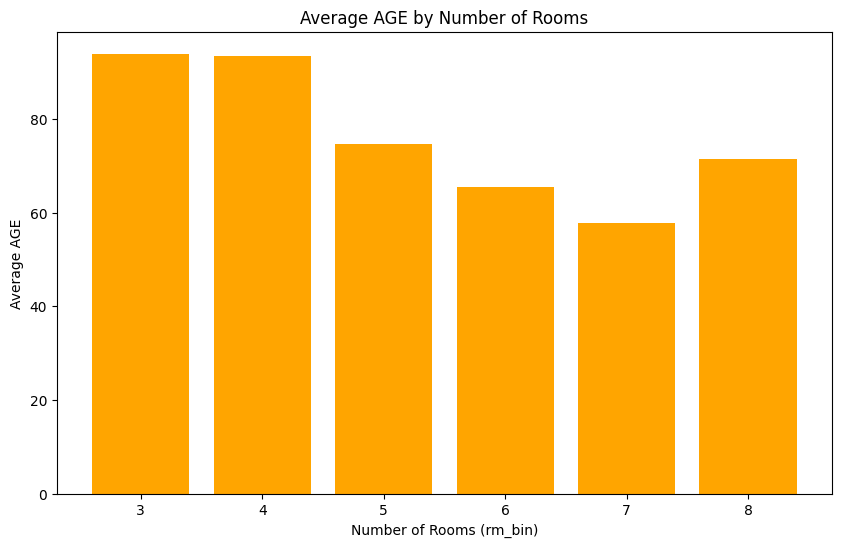

In [19]:
# Bar chart for average_AGE
plt.figure(figsize=(10, 6))
plt.bar(statistics_pd['rm_bin'], statistics_pd['average_age'], color='orange')
plt.xlabel('Number of Rooms (rm_bin)')
plt.ylabel('Average AGE')
plt.title('Average AGE by Number of Rooms')
plt.show()

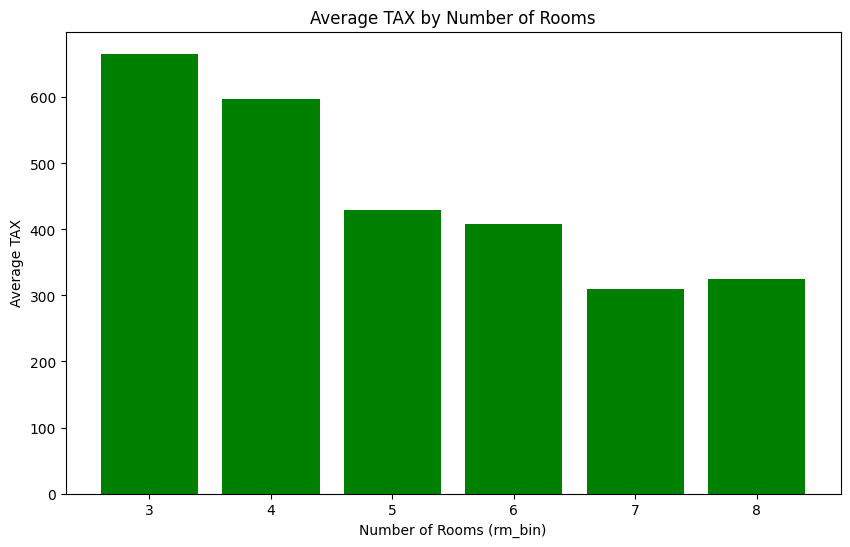

In [20]:
# Bar chart for average_TAX
plt.figure(figsize=(10, 6))
plt.bar(statistics_pd['rm_bin'], statistics_pd['average_tax'], color='green')
plt.xlabel('Number of Rooms (rm_bin)')
plt.ylabel('Average TAX')
plt.title('Average TAX by Number of Rooms')
plt.show()

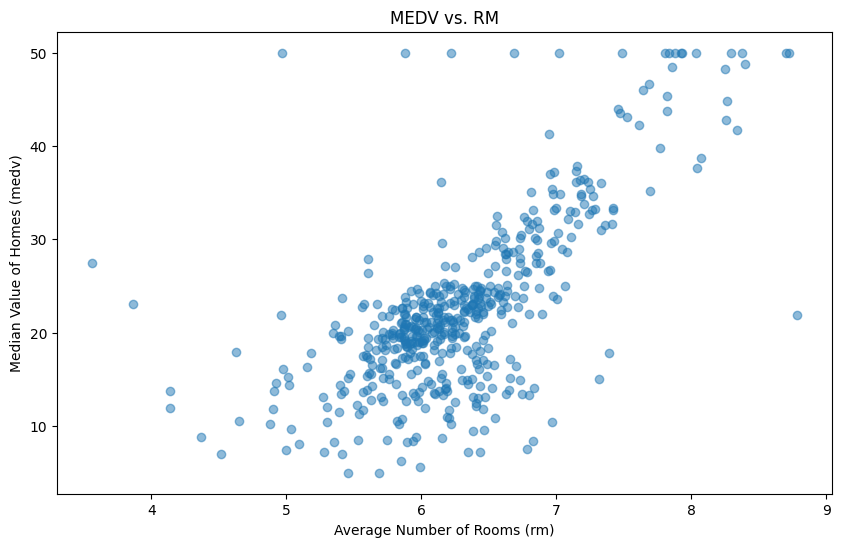

In [21]:
# Scatter plot of MEDV vs. RM
plt.figure(figsize=(10, 6))
plt.scatter(data.toPandas()['rm'], data.toPandas()['medv'], alpha=0.5)
plt.xlabel('Average Number of Rooms (rm)')
plt.ylabel('Median Value of Homes (medv)')
plt.title('MEDV vs. RM')
plt.show()

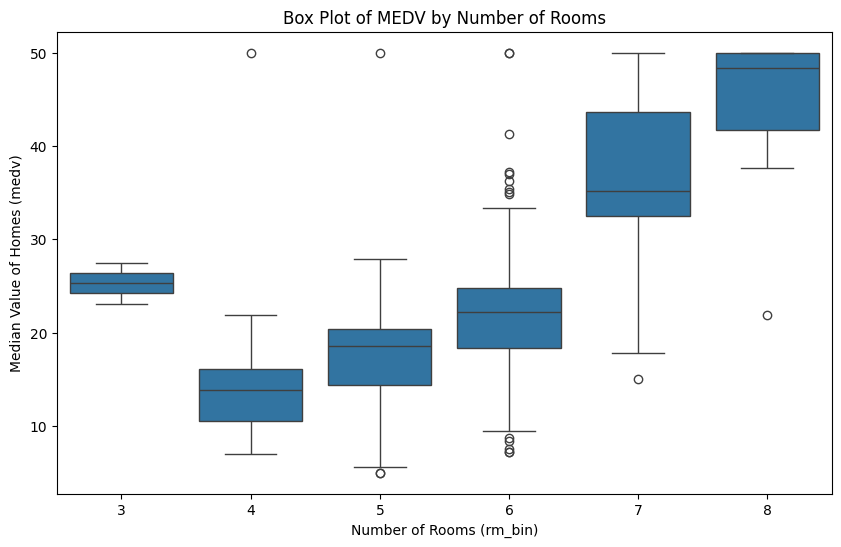

In [22]:
import seaborn as sns
# Box plot of MEDV by RM_bin
plt.figure(figsize=(10, 6))
data_pd = data.toPandas()
data_pd['rm_bin'] = data_pd['rm'].astype(int)
sns.boxplot(x='rm_bin', y='medv', data=data_pd)
plt.xlabel('Number of Rooms (rm_bin)')
plt.ylabel('Median Value of Homes (medv)')
plt.title('Box Plot of MEDV by Number of Rooms')
plt.show()


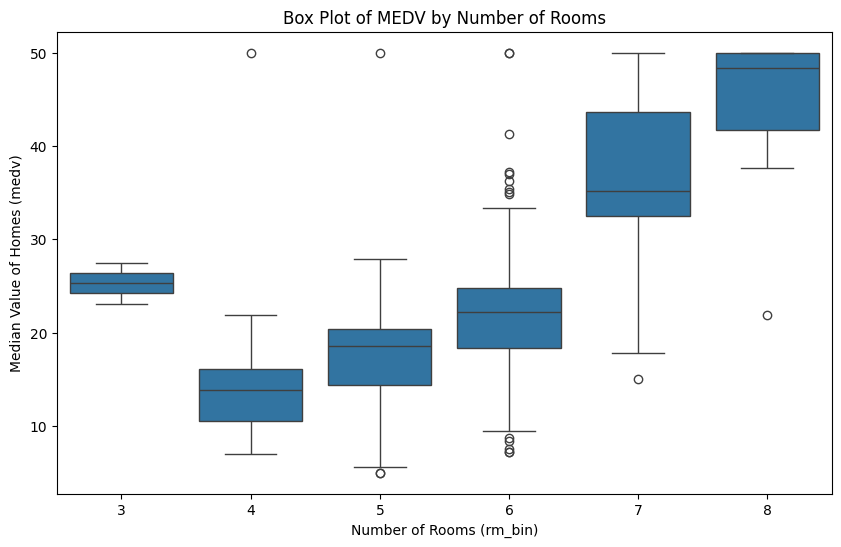

In [23]:
# Box plot of MEDV by RM_bin
plt.figure(figsize=(10, 6))
data_pd = data.toPandas()
data_pd['rm_bin'] = data_pd['rm'].astype(int)
sns.boxplot(x='rm_bin', y='medv', data=data_pd)
plt.xlabel('Number of Rooms (rm_bin)')
plt.ylabel('Median Value of Homes (medv)')
plt.title('Box Plot of MEDV by Number of Rooms')
plt.show()

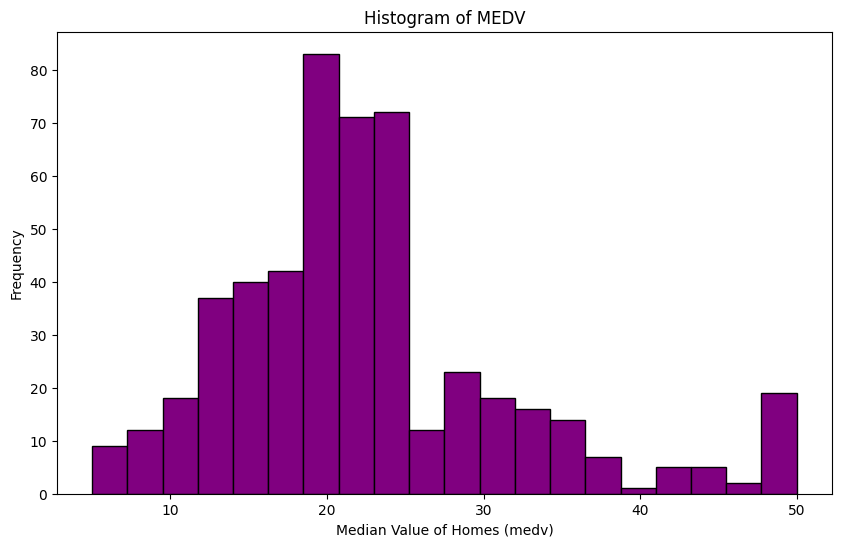

In [24]:
# Histogram of MEDV
plt.figure(figsize=(10, 6))
plt.hist(data.toPandas()['medv'], bins=20, color='purple', edgecolor='black')
plt.xlabel('Median Value of Homes (medv)')
plt.ylabel('Frequency')
plt.title('Histogram of MEDV')
plt.show()


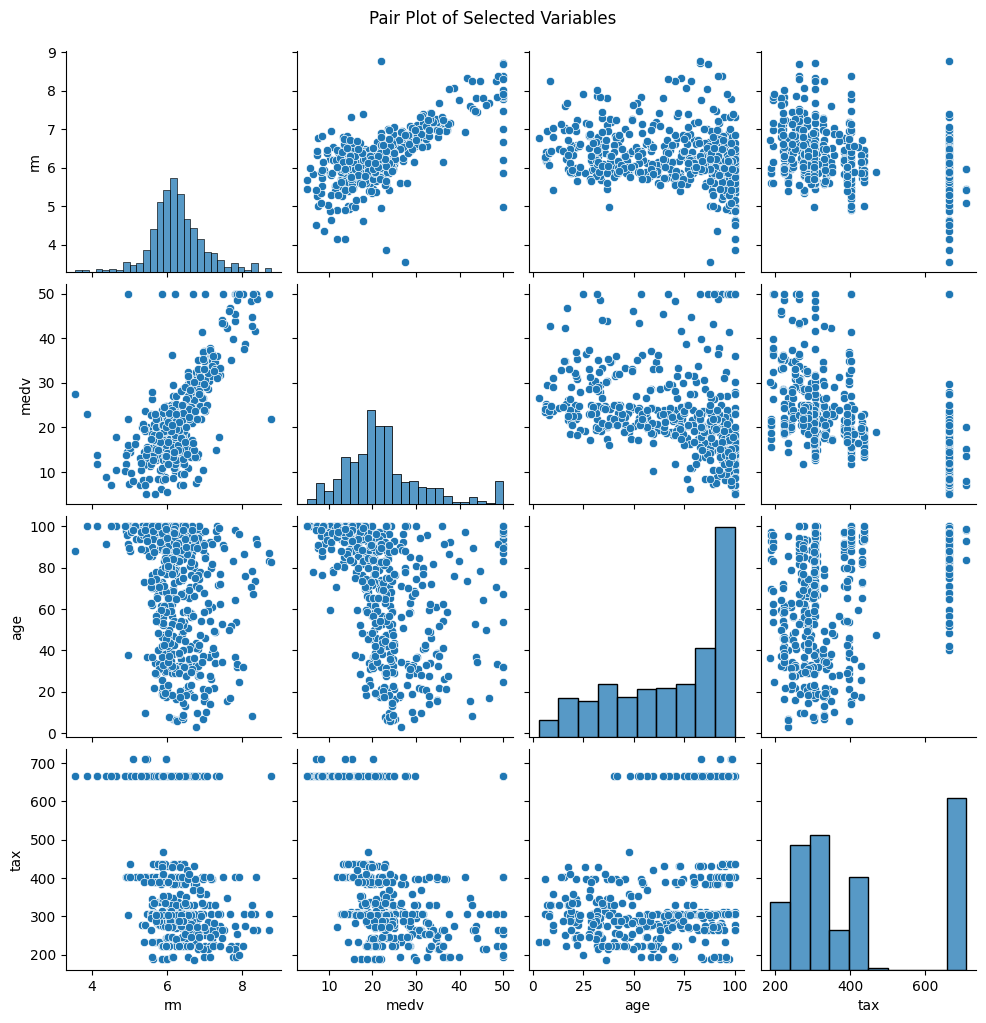

In [25]:
# Pair plot of selected variables
#import seaborn as sns

selected_columns = ['rm', 'medv', 'age', 'tax']
sns.pairplot(data.toPandas()[selected_columns])
plt.suptitle('Pair Plot of Selected Variables', y=1.02)
plt.show()
